In [42]:
#!pip install opencv-python
#!pip install pillow

In [43]:
#pip install gym==0.21.0

In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym 
import random

from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL

In [45]:
#configuration variables can be tweaked to manipulate difficulty, reward structure and appearance of the environment
CONFIG={
    "OBSERVATION_W":500,#screen width
    "OBSERVATION_H":500,#screen height
    "BUG_SPAWN_PROB":0.05,
    "AMMO_SPAWN_PROB":0.01,
    "EPISODE_LENGTH": 500,
    "MAX_BULLETS": 50,
    "STEP_REW":-0.001,
    "BUG_KILL_REW": 7,
    "LEP_COLLISION_REW": -10,
    "AMMO_COLLECT_REW": 2,
    "BULLET_USE_REW":-0.3
}

In [46]:
class LepScape(Env):
    def __init__(self, show_status=False, config=CONFIG):
        super(LepScape, self).__init__()
        
        self.config=config
        
        
        #Define a 2-D observation space
        self.observation_shape=(500, 500, 1)
        self.observation_space = spaces.Box(low=0,
                                            high = 255,
                                            shape=(500, 500, 1),
                                            dtype = np.uint8)
        
        # Define an action space ranging from 0 to 6
        self.action_space = spaces.Discrete(7)
        
        # Create a canvas to render the environment images upon
        self.canvas= np.ones((500, 500, 1), dtype=np.uint8)
    
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum bullets leprechaun can take at once
        self.max_bullets = self.config["MAX_BULLETS"]
        
        
        # Permissible area of leprechaun to be
        self.y_min = 0
        self.x_min = 0
        
        self.y_max = self.observation_shape[0]
        self.x_max = self.observation_shape[1]
        
        # episode length in timesteps
        self.ep_length =self.config["EPISODE_LENGTH"]
        
        self.show_status=show_status
        
    def draw_elements_on_canvas(self):
        # Init the canvas 
        #self.canvas = np.ones(self.observation_shape) * 1
        self.canvas= np.ones((500, 500, 1), dtype=np.uint8)

        # Draw the leprechaun on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon
            
        if self.show_status==True:
            #show full rewards and status
            text = 'bullets Left: {} | Rewards: {} | time left: {}'.format(self.bullets_left, "{:.2f}".format(self.ep_return), self.ep_length)
            
            # Put the info on canvas 
            self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (255,255,255), 1, cv2.LINE_AA)
        
        elif self.show_status=="training":
            #bullets left is only relevant metric for training
            text = 'bullets Left: {}'.format(self.bullets_left)
            
            # Put the info on canvas 
            self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (255,255,255), 1, cv2.LINE_AA)
        else:
            pass


    def reset(self):
        #reset the time
        self.ep_length = self.config["EPISODE_LENGTH"]
        
        # Reset the bullets used
        self.bullets_left = self.max_bullets

        # Reset the reward
        self.ep_return  = 0

        # Number of bugs and ammo
        self.bug_count = 0
        self.ammo_count = 0
        
        # return to info
        self.ep_kill_count=0
        self.ep_bullets_used=0
        self.ep_died=False
        self.ep_ammo_collected=0

        # leprechaun spawns in bottom middle of the screen
        x = int(self.observation_shape[0]/2)
        y = self.y_max 
        
        #initialize background
        self.bg=Bg("bg",self.x_max, self.x_min, self.y_max, self.y_min)
        xbg=0
        ybg= 0
        self.bg.set_position(xbg, ybg)

        # Intialise the leprechaun
        self.leprechaun = Leprechaun("leprechaun", self.x_max, self.x_min, self.y_max, self.y_min)
        self.leprechaun.set_position(x,y)
        
       

        # Intialise the elements 
        self.elements = [self.bg, self.leprechaun]
        #self.elements = [self.leprechaun]

        # Reset the Canvas 
        #self.canvas = np.ones(self.observation_shape) * 1
        self.canvas= np.ones((500, 500, 1), dtype=np.uint8)

        # Draw elements on the canvas
        self.draw_elements_on_canvas()


        return self.canvas
    #render the environment
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Game", self.canvas)
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.canvas
    
    def close(self):
        cv2.destroyAllWindows()
    
    #actions the leprechaun can take
    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4:"shoot", 5: "Do Nothing"}
    
    #check for collisions between elements
    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col = True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True

        return False
    
    #the step function advances the environment by one frame
    def step(self, action):        
        # Flag that marks the termination of an episode
        done = False

        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the time 
        self.ep_length -= 1 

        # Reward for executing a step (agent gets small penalty  for continue to exist without doing anything notable).
        reward = self.config["STEP_REW"]     

        # apply the action to the leprechaun
        if action == 0:
            self.leprechaun.move(0,5)
        elif action == 1:
            self.leprechaun.move(0,-5)
        elif action == 2:
            self.leprechaun.move(5,0)
        elif action == 3:
            self.leprechaun.move(-5,0)
        elif action == 4:
            if self.bullets_left>0:
                 # Spawn a bullet
                spawned_bullet = Bullet("bullet_{}".format(self.bullets_left), self.x_max, self.x_min, self.y_max, self.y_min)
                self.bullets_left -= 1
                self.ep_bullets_used+=1

                bullet_x, bullet_y = self.leprechaun.get_position()
                bullet_x=bullet_x+int(self.leprechaun.icon_w/2)
                spawned_bullet.set_position(bullet_x, bullet_y)

                # Append the spawned bullet to the elements currently present in Env. 
                self.elements.append(spawned_bullet) 
                spawned_bullet.move(0,-5)
                #small penalty for firing a bullet
                reward+=self.config["BULLET_USE_REW"]
        elif action == 5:
            pass

        # Spawn a bug at the top edge with prob 0.01
        if random.random() < self.config["BUG_SPAWN_PROB"]:

            # Spawn a bug
            spawned_bug = Bug("bug_{}".format(self.bug_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.bug_count += 1

            # Compute the x,y co-ordinates of the position from where the bug has to be spawned
            # Horizontally, the position randomly and vertically, the bug is spawned at the top edge 
            # sampled from the set of permissible values            
            bug_x = random.randrange(self.x_min, self.x_max)
            bug_y = self.y_min
            spawned_bug.set_position(bug_x, bug_y)

            # Append the spawned bug to the elements currently present in Env. 
            self.elements.append(spawned_bug)    

        # Spawn an ammo pack at the top edge with prob 0.01
        if random.random() < self.config["AMMO_SPAWN_PROB"]:
            # Spawn an ammo pack
            spawned_ammo = Ammo("ammo_{}".format(self.ammo_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.ammo_count += 1

            # Compute the x,y co-ordinates of the position from where the ammo pack has to be spawned
            # Horizontally, the position is randomly chosen from the list of permissible values and 
            # vertically, the position is at the top edge            
            ammo_x = random.randrange(self.x_min, self.x_max)
            ammo_y = self.y_min
            spawned_ammo.set_position(ammo_x, ammo_y)

            # Append the spawned ammo to the elemetns currently present in the Env.
            self.elements.append(spawned_ammo)   

        
        #check for bug collisions with bullet and update reward 
        bugs_and_bullets= [elem for elem in self.elements if (isinstance(elem, Bullet) or isinstance(elem, Bug))]
        
        for i, elem1 in enumerate(bugs_and_bullets):
            for j in range(i+1,len(bugs_and_bullets)):
                elem2=bugs_and_bullets[j]
                #check for collision of bullet and bug
                if self.has_collided(elem1, elem2) and (type(elem1)!=type(elem2)):
                    #remove the bug and the bullet from screen
                    try: 
                        #large reward for killing bug
                        reward +=self.config["BUG_KILL_REW"]
                        self.ep_kill_count+=1
                        
                        self.elements=[elem for elem in self.elements if (elem!=elem1) and (elem!=elem2)]
                        #self.draw_elements_on_canvas()
                        break;
                    except Exception as e:
                        print("element removal error bugbull", e)

        #update rest of elements                    
        for elem in self.elements[:]:
            if isinstance(elem, Bug): 
                # If the bug has reached the bottom edge, remove it from the Env
                if elem.get_position()[1] >= self.y_max-elem.icon_w:
                    self.elements.remove(elem)
                else:
                    # Move the bug down by 5 pts.
                    elem.move(0,5)

                # If the bug has collided with the leprechaun end the episode
                if self.has_collided(self.leprechaun, elem):
                    # Conclude the episode and remove the lep from the Env.
                    done = True
                    #large penalty for colliding with bug
                    reward +=self.config["LEP_COLLISION_REW"]
                    self.ep_died=True
                    try:
                        self.elements.remove(self.leprechaun)
                    except Exception as e:
                        print("element removal error leprechaun")
                        
                
                        
            if isinstance(elem, Ammo):
                # If the ammo pack has collided with the leprechaun.
                if self.has_collided(self.leprechaun, elem):
                    try: 
                        # Remove the ammo pack from the env.
                        self.elements.remove(elem)
                        reward +=self.config["AMMO_COLLECT_REW"]
                        self.ep_ammo_collected+=1
                        # update ammo left of the leprechaun to full.
                        self.bullets_left = self.max_bullets
                    except Exception as e:
                        print("element removal error ammo", e)
                        #pass
                        
                # If the ammo pack has reached the bottom, remove it from the Env
                elif elem.get_position()[1] >= self.y_max-elem.icon_w:
                    self.elements.remove(elem)
                    
                else:
                    # Move the ammo down by 5 pts.
                    elem.move(0, 5)

                

            if isinstance(elem, Bullet):
                # If the bullet has reached the top edge, remove it from the Env
                if elem.get_position()[1] <= self.y_min:
                    self.elements.remove(elem)
                else:
                    # Move the bullet up by 5 pts.
                    elem.move(0, -5)


        # Increment the episodic return
        self.ep_return += reward

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of time, end the episode.
        if self.ep_length == 0:
            done = True
            self.ep_died=False
        
        #return the enironment rewards as well as some useful information about the episode
        return self.canvas, reward, done, {
            "ep_kill_count":self.ep_kill_count,
            "ep_bullets_used":self.ep_bullets_used,
            "ep_died":self.ep_died,
            "ep_ammo_collected":self.ep_ammo_collected,
            "ep_length":self.ep_length
        }

In [47]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
        
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

In [48]:
class Leprechaun(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Leprechaun, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("lep2.png")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))
    
class Bug(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bug, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("bug.png")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))
    
class Ammo(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Ammo, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("ammo.png")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))

class Bullet(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bullet, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("shamrock.png")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = 10
        self.icon_h = 10
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))

class Bg(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bg, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("bg.jpg")
        self.icon = cv2.cvtColor(self.icon, cv2.COLOR_BGR2GRAY)
        self.icon = self.icon[:, :, np.newaxis]
        self.icon_w = x_max
        self.icon_h = y_max
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w), interpolation=cv2.INTER_CUBIC)
        self.icon=np.reshape(self.icon, (self.icon_h,self.icon_w,1))

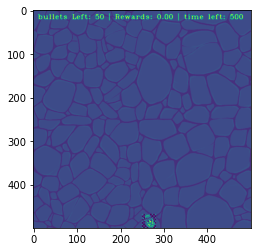

In [49]:
env = LepScape(show_status=True)
obs = env.reset()
screen = env.render(mode = "rgb_array")
plt.imshow(screen)

In [52]:
# test environment
from IPython import display
import statistics

env = LepScape(show_status=True)
obs = env.reset()

r_total_kill=[]
r_total_bullets=[]
r_total_ammo_collected=[]
r_ep_length=[]
r_rewards=[]
r_died=[]

for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action=env.action_space.sample()
        obs, reward, done, info = env.step(action)
        
        env.render()
        total_reward += reward
    print('Episode: {} | Total Reward: {} | killcount: {} bullets used: {}'
          .format(episode,total_reward,info["ep_kill_count"], info["ep_bullets_used"] ))
    
    r_total_kill.append(info["ep_kill_count"])
    r_total_bullets.append(info["ep_bullets_used"])
    r_total_ammo_collected.append(info["ep_ammo_collected"])
    r_rewards.append(total_reward)
    r_ep_length.append(info["ep_length"])
    r_died.append(info["ep_died"])    

bpk=sum(r_total_bullets)/sum(r_total_kill)
random_summary=(("total_kill: {} | total_bullets_used: {} | total_ammo_collected: {} | avg_kill: {} |"
                " avg_bullets_used: {} \nbullets_per_kill: {} | ep_len_mean:{} | reward_mean: {} | death_count: {}")
                .format(sum(r_total_kill), sum(r_total_bullets), sum(r_total_ammo_collected),
                statistics.mean(r_total_kill), statistics.mean(r_total_bullets), bpk,
                statistics.mean(r_ep_length),statistics.mean(r_rewards), sum(r_died)))
print('\n'+random_summary)

Episode: 0 | Total Reward: -15.499999999999838 | killcount: 0 bullets used: 50
Episode: 1 | Total Reward: 12.50000000000003 | killcount: 4 bullets used: 50
Episode: 2 | Total Reward: 9.51399999999967 | killcount: 5 bullets used: 50
Episode: 3 | Total Reward: -3.132999999999938 | killcount: 3 bullets used: 46
Episode: 4 | Total Reward: -15.230999999999998 | killcount: 0 bullets used: 17

total_kill: 12 | total_bullets_used: 213 | total_ammo_collected: 0 | avg_kill: 2.4 | avg_bullets_used: 42.6 
bullets_per_kill: 17.75 | ep_len_mean:110 | reward_mean: -2.3700000000000148 | death_count: 3


In [53]:

env.close()

# Training the Leprechaun Environment

# View Game State And Check Environment

In [54]:
env=LepScape(show_status="training", config=CONFIG)

In [55]:
env.reset()

array([[[59],
        [58],
        [57],
        ...,
        [60],
        [60],
        [59]],

       [[59],
        [58],
        [58],
        ...,
        [59],
        [60],
        [59]],

       [[59],
        [58],
        [58],
        ...,
        [59],
        [60],
        [59]],

       ...,

       [[58],
        [58],
        [58],
        ...,
        [59],
        [58],
        [58]],

       [[58],
        [58],
        [58],
        ...,
        [59],
        [58],
        [58]],

       [[58],
        [58],
        [58],
        ...,
        [59],
        [58],
        [58]]], dtype=uint8)

In [56]:
#!pip install stable-baselines3[extra]

In [57]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [58]:
# check environment compliant and ready for ppo training
env_checker.check_env(env)

In [59]:
env.close()

## Setup Callback

In [60]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html --user

In [61]:
#use this if memory error
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html --no-cache-dir

In [62]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [63]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_7_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [64]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [65]:
#log metrics and save weights every 10000 epochs
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Train Model

In [66]:
# import ppo for training
from stable_baselines3 import PPO

In [67]:
# Non rendered environment
env = LepScape(show_status="training")

In [36]:
#create the model
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.001, n_steps=4096)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [37]:
#model.load('./train/train_basic/best_model_6_100000')

In [38]:
#train the model with ppo for n_timesteps
model.set_env(env)
model.learn(total_timesteps=500000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_basic\PPO_10
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 334      |
|    ep_rew_mean     | 1.24     |
| time/              |          |
|    fps             | 59       |
|    iterations      | 1        |
|    time_elapsed    | 68       |
|    total_timesteps | 4096     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 316        |
|    ep_rew_mean          | -0.164     |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 2          |
|    time_elapsed         | 1065       |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.07657404 |
|    clip_fraction        | 0.288      |
|    clip_range

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 386        |
|    ep_rew_mean          | 5.97       |
| time/                   |            |
|    fps                  | 4          |
|    iterations           | 11         |
|    time_elapsed         | 10194      |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.16481179 |
|    clip_fraction        | 0.67       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.79      |
|    explained_variance   | 0.142      |
|    learning_rate        | 0.001      |
|    loss                 | -0.106     |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.0851    |
|    value_loss           | 0.349      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 395        |
|    ep_rew_mean

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 412       |
|    ep_rew_mean          | 12.5      |
| time/                   |           |
|    fps                  | 4         |
|    iterations           | 21        |
|    time_elapsed         | 20192     |
|    total_timesteps      | 86016     |
| train/                  |           |
|    approx_kl            | 0.2069796 |
|    clip_fraction        | 0.691     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.69     |
|    explained_variance   | 0.155     |
|    learning_rate        | 0.001     |
|    loss                 | -0.101    |
|    n_updates            | 200       |
|    policy_gradient_loss | -0.0898   |
|    value_loss           | 0.368     |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 410        |
|    ep_rew_mean          | 11.6     

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 399        |
|    ep_rew_mean          | 7.92       |
| time/                   |            |
|    fps                  | 4          |
|    iterations           | 31         |
|    time_elapsed         | 30223      |
|    total_timesteps      | 126976     |
| train/                  |            |
|    approx_kl            | 0.19035766 |
|    clip_fraction        | 0.726      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.68      |
|    explained_variance   | 0.396      |
|    learning_rate        | 0.001      |
|    loss                 | -0.129     |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.105     |
|    value_loss           | 0.297      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 401        |
|    ep_rew_mean

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 412        |
|    ep_rew_mean          | 9.7        |
| time/                   |            |
|    fps                  | 4          |
|    iterations           | 41         |
|    time_elapsed         | 40632      |
|    total_timesteps      | 167936     |
| train/                  |            |
|    approx_kl            | 0.27296942 |
|    clip_fraction        | 0.74       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.62      |
|    explained_variance   | 0.358      |
|    learning_rate        | 0.001      |
|    loss                 | -0.113     |
|    n_updates            | 400        |
|    policy_gradient_loss | -0.0969    |
|    value_loss           | 0.337      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 411        |
|    ep_rew_mean

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 449       |
|    ep_rew_mean          | 12.4      |
| time/                   |           |
|    fps                  | 4         |
|    iterations           | 51        |
|    time_elapsed         | 51646     |
|    total_timesteps      | 208896    |
| train/                  |           |
|    approx_kl            | 0.2673416 |
|    clip_fraction        | 0.737     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.6      |
|    explained_variance   | 0.478     |
|    learning_rate        | 0.001     |
|    loss                 | -0.112    |
|    n_updates            | 500       |
|    policy_gradient_loss | -0.101    |
|    value_loss           | 0.283     |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 443       |
|    ep_rew_mean          | 11.9      |


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 419        |
|    ep_rew_mean          | 10.5       |
| time/                   |            |
|    fps                  | 3          |
|    iterations           | 61         |
|    time_elapsed         | 62753      |
|    total_timesteps      | 249856     |
| train/                  |            |
|    approx_kl            | 0.29003966 |
|    clip_fraction        | 0.747      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.6       |
|    explained_variance   | 0.256      |
|    learning_rate        | 0.001      |
|    loss                 | -0.104     |
|    n_updates            | 600        |
|    policy_gradient_loss | -0.0893    |
|    value_loss           | 0.388      |
----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 409       |
|    ep_rew_mean   

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 8.19       |
| time/                   |            |
|    fps                  | 3          |
|    iterations           | 71         |
|    time_elapsed         | 73463      |
|    total_timesteps      | 290816     |
| train/                  |            |
|    approx_kl            | 0.26486713 |
|    clip_fraction        | 0.723      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.52      |
|    explained_variance   | 0.538      |
|    learning_rate        | 0.001      |
|    loss                 | -0.114     |
|    n_updates            | 700        |
|    policy_gradient_loss | -0.099     |
|    value_loss           | 0.257      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 406        |
|    ep_rew_mean

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 409       |
|    ep_rew_mean          | 12.1      |
| time/                   |           |
|    fps                  | 3         |
|    iterations           | 81        |
|    time_elapsed         | 85161     |
|    total_timesteps      | 331776    |
| train/                  |           |
|    approx_kl            | 0.3176251 |
|    clip_fraction        | 0.749     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.52     |
|    explained_variance   | 0.374     |
|    learning_rate        | 0.001     |
|    loss                 | -0.0992   |
|    n_updates            | 800       |
|    policy_gradient_loss | -0.0928   |
|    value_loss           | 0.467     |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 408        |
|    ep_rew_mean          | 11       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 377        |
|    ep_rew_mean          | 8.85       |
| time/                   |            |
|    fps                  | 3          |
|    iterations           | 91         |
|    time_elapsed         | 97239      |
|    total_timesteps      | 372736     |
| train/                  |            |
|    approx_kl            | 0.30175948 |
|    clip_fraction        | 0.735      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.48      |
|    explained_variance   | 0.39       |
|    learning_rate        | 0.001      |
|    loss                 | -0.0781    |
|    n_updates            | 900        |
|    policy_gradient_loss | -0.0915    |
|    value_loss           | 0.544      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 382        |
|    ep_rew_mean

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 408       |
|    ep_rew_mean          | 9.73      |
| time/                   |           |
|    fps                  | 3         |
|    iterations           | 101       |
|    time_elapsed         | 109887    |
|    total_timesteps      | 413696    |
| train/                  |           |
|    approx_kl            | 0.3338954 |
|    clip_fraction        | 0.729     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.46     |
|    explained_variance   | 0.622     |
|    learning_rate        | 0.001     |
|    loss                 | -0.0976   |
|    n_updates            | 1000      |
|    policy_gradient_loss | -0.0925   |
|    value_loss           | 0.453     |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 406        |
|    ep_rew_mean          | 10.1     

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 407       |
|    ep_rew_mean          | 10        |
| time/                   |           |
|    fps                  | 3         |
|    iterations           | 111       |
|    time_elapsed         | 122149    |
|    total_timesteps      | 454656    |
| train/                  |           |
|    approx_kl            | 0.3263786 |
|    clip_fraction        | 0.733     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.41     |
|    explained_variance   | 0.524     |
|    learning_rate        | 0.001     |
|    loss                 | -0.0925   |
|    n_updates            | 1100      |
|    policy_gradient_loss | -0.0942   |
|    value_loss           | 0.417     |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 397        |
|    ep_rew_mean          | 8.6      

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 456261632 bytes.

# Test the Model

In [68]:
import os

In [69]:
print(os.getcwd())

D:\cct\lepenv\RL_Game_AI-nicholas\RL_Game_AI-nicholas\lep_env_gray


In [70]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
#Note: all files including select weights for this environment can be accessed and downloaded here
#https://drive.google.com/file/d/1fFpMW7MBcS_1NmwtRANqqqcMvI91eUtC/view?usp=sharing

In [71]:
# Reload model from disc
model = PPO.load('./train/train_basic/best_model_6_230000')

In [25]:
# Create rendered environment
env = LepScape(show_status=True)

In [72]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)

C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [73]:
mean_reward

-6.810400184569881

In [74]:
model.predict(obs)

(6, None)

In [75]:
# test env
from IPython import display
import statistics

In [76]:
%%time
env = LepScape(show_status=True)
obs = env.reset()

r_total_kill=[]
r_total_bullets=[]
r_total_ammo_collected=[]
r_ep_length=[]
r_rewards=[]
r_died=[]

for episode in range(100): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action=env.action_space.sample()
        obs, reward, done, info = env.step(action)
        
        #env.render()
        total_reward += reward
    print('Episode: {} | Total Reward: {} | killcount: {} bullets used: {}'
          .format(episode,total_reward,info["ep_kill_count"], info["ep_bullets_used"] ))
    
    r_total_kill.append(info["ep_kill_count"])
    r_total_bullets.append(info["ep_bullets_used"])
    r_total_ammo_collected.append(info["ep_ammo_collected"])
    r_rewards.append(total_reward)
    r_ep_length.append(info["ep_length"])
    r_died.append(info["ep_died"])    

bpk=sum(r_total_bullets)/sum(r_total_kill)
random_summary=(("total_kill: {} | total_bullets_used: {} | total_ammo_collected: {} | avg_kill: {} |"
                " avg_bullets_used: {} \nbullets_per_kill: {} | ep_len_mean:{} | reward_mean: {} | death_count: {}")
                .format(sum(r_total_kill), sum(r_total_bullets), sum(r_total_ammo_collected),
                statistics.mean(r_total_kill), statistics.mean(r_total_bullets), bpk,
                statistics.mean(r_ep_length),statistics.mean(r_rewards), sum(r_died)))
print('\n'+random_summary)

Episode: 0 | Total Reward: -8.259999999999998 | killcount: 1 bullets used: 17
Episode: 1 | Total Reward: -18.34399999999998 | killcount: 1 bullets used: 50
Episode: 2 | Total Reward: -1.500000000000015 | killcount: 2 bullets used: 50
Episode: 3 | Total Reward: 19.499999999999805 | killcount: 5 bullets used: 50
Episode: 4 | Total Reward: 26.499999999999794 | killcount: 6 bullets used: 50
Episode: 5 | Total Reward: -4.094999999999972 | killcount: 3 bullets used: 49
Episode: 6 | Total Reward: -5.790000000000051 | killcount: 3 bullets used: 61
Episode: 7 | Total Reward: -15.71500000000002 | killcount: 0 bullets used: 25
Episode: 8 | Total Reward: -8.49999999999987 | killcount: 1 bullets used: 50
Episode: 9 | Total Reward: -25.378999999999905 | killcount: 0 bullets used: 50
Episode: 10 | Total Reward: -16.106 | killcount: 0 bullets used: 20
Episode: 11 | Total Reward: -1.499999999999985 | killcount: 2 bullets used: 50
Episode: 12 | Total Reward: -1.4999999999999791 | killcount: 2 bullets us

In [86]:
%%time
env = LepScape(show_status=True)
obs = env.reset()

t_total_kill=[]
t_total_bullets=[]
t_total_ammo_collected=[]
t_ep_length=[]
t_rewards=[]
t_died=[]

for episode in range(100): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _= model.predict(obs)
        obs, reward, done, info = env.step(action)
        
        #env.render()
        total_reward += reward
    print('Episode: {} | Total Reward: {} | killcount: {} bullets used: {}'
          .format(episode,total_reward,info["ep_kill_count"], info["ep_bullets_used"] ))
    
    t_total_kill.append(info["ep_kill_count"])
    t_total_bullets.append(info["ep_bullets_used"])
    t_total_ammo_collected.append(info["ep_ammo_collected"])
    t_rewards.append(total_reward)
    t_ep_length.append(info["ep_length"])
    t_died.append(info["ep_died"])

bpk=sum(t_total_bullets)/sum(t_total_kill)
rl_agent_summary=(("total_kill: {} | total_bullets_used: {} | total_ammo_collected: {} | avg_kill: {} |"
                " avg_bullets_used: {} \nbullets_per_kill: {} | ep_len_mean:{} | reward_mean: {} | death_count: {}")
                .format(sum(t_total_kill), sum(t_total_bullets), sum(t_total_ammo_collected),
                statistics.mean(t_total_kill), statistics.mean(t_total_bullets), bpk,
                statistics.mean(t_ep_length),statistics.mean(t_rewards), sum(t_died)))
print('\n'+rl_agent_summary)

Episode: 0 | Total Reward: -4.783000000000016 | killcount: 2 bullets used: 28
Episode: 1 | Total Reward: 0.7880000000000393 | killcount: 2 bullets used: 10
Episode: 2 | Total Reward: -5.221000000000004 | killcount: 1 bullets used: 7
Episode: 3 | Total Reward: -4.409000000000066 | killcount: 1 bullets used: 17
Episode: 4 | Total Reward: 8.800000000000002 | killcount: 3 bullets used: 39
Episode: 5 | Total Reward: 12.499999999999973 | killcount: 4 bullets used: 50
Episode: 6 | Total Reward: 7.041999999999983 | killcount: 4 bullets used: 35
Episode: 7 | Total Reward: 21.89999999999989 | killcount: 5 bullets used: 42
Episode: 8 | Total Reward: 2.696000000000069 | killcount: 3 bullets used: 33
Episode: 9 | Total Reward: 9.400000000000139 | killcount: 3 bullets used: 37
Episode: 10 | Total Reward: -1.4999999999999778 | killcount: 2 bullets used: 50
Episode: 11 | Total Reward: -7.947999999999991 | killcount: 1 bullets used: 16
Episode: 12 | Total Reward: -12.249999999999991 | killcount: 0 bull

In [87]:
#Total Kill over 100 epochs
print("Total Kill:")
"Random Agent: {}".format(sum(r_total_kill)), "Trained Agent: {}".format(sum(t_total_kill))

Total Kill:


('Random Agent: 296', 'Trained Agent: 320')

In [88]:
#Total Bullets Used over 100 epochs
print("Total Bullets Used:")
"Random Agent: {}".format(sum(r_total_bullets)), "Trained Agent: {}".format(sum(t_total_bullets))

Total Bullets Used:


('Random Agent: 4569', 'Trained Agent: 3485')

In [89]:
#Bullet to kill Ratio
print("Bullets Per Kill Ratio:")
bpk_r=sum(r_total_bullets)/sum(r_total_kill)
bpk_t=sum(t_total_bullets)/sum(t_total_kill)
"Random Agent: {}".format(bpk_r), "Trained Agent: {}".format(bpk_t)

Bullets Per Kill Ratio:


('Random Agent: 15.43581081081081', 'Trained Agent: 10.890625')

In [90]:
#Total Ammo Packs collected
print("Total Ammo Packs Picked:")
"Random Agent: {}".format(sum(r_total_ammo_collected)), "Trained Agent: {}".format(sum(t_total_ammo_collected))

Total Ammo Packs Picked:


('Random Agent: 30', 'Trained Agent: 36')

In [91]:
#Episode Reward Mean
print("Episode Reward Mean:")
"Random Agent: {}".format(statistics.mean(r_rewards)), "Trained Agent: {}".format(statistics.mean(t_rewards))

Episode Reward Mean:


('Random Agent: 1.5398200000000195', 'Trained Agent: 7.965729999999998')

In [92]:
#Episode Length Mean
print("Episode Length Mean:")
"Random Agent: {}".format(statistics.mean(r_ep_length)), "Trained Agent: {}".format(statistics.mean(t_ep_length))

Episode Length Mean:


('Random Agent: 126.82', 'Trained Agent: 100.73')

In [93]:
#Number of Deaths
print("Number of Deaths:")
"Random Agent: {}".format(sum(r_died)), "Trained Agent: {}".format(sum(t_died))

Number of Deaths:


('Random Agent: 57', 'Trained Agent: 43')

In [94]:
env.close()